In [1]:
import numpy as np
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import pathlib as pl
import dill

import candas as can
import gumbi as gmb
from candas.learn import ParameterSet

from tqdm.auto import tqdm

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))


In [2]:
with open(gen_pth / 'Model_Avg_predictions.pkl', 'rb') as f:
    avg_model_r = dill.load(f)['r']

In [10]:
fig_num = 'S1'
# plt.style.use('style.mplstyle')

%config InlineBackend.figure_format = 'retina'

panel = None
subpanel = None

def savefig(fig=None, title=None):
    fig = fig or plt.gcf()
    title = title or 'Fig_'+'_'.join([str(el) for el in [fig_num, panel, subpanel] if el is not None])
    print(f'Saving {title} in {graph_pth}:', end='')
    for ext in ['svg', 'png']:
        try:
            fig.savefig(graph_pth / f'{title}.{ext}', dpi=600, transparent=True)
            print(f' [.{ext}]', end='')
        except AttributeError:
            print(f' [.{ext} failed]', end='')
    print(' done')

In [3]:


ps = ParameterSet.load(data_pth / 'ADVI_ParameterSets_220528.pkl')
def make_pair(row):
    return '-'.join(sorted([row.FPrimer, row.RPrimer]))

data = (ps.wide
        .query('Metric == "mean"')
        .astype({'BP': float})
        .assign(PrimerPair = lambda df: df.apply(make_pair, axis=1))
        .groupby(['Target', 'PrimerPair','Reporter'])
        .mean(numeric_only=True)
        .reset_index()
        )

selected = (data
 .groupby(['PrimerPair', 'Reporter'])
 .size()
 .reset_index()
 .rename(columns={0:'Observations'})
 .sort_values('Observations', ascending=False)
 .reset_index(drop=True)
).iloc[[0, 1, 4, 5, 6, 8, 38, 39, 42]]


In [4]:
ds_full = gmb.DataSet(
            data = data,
            outputs = ['F0_lg', 'r', 'K', 'm'],
            log_vars = ['BP', 'K', 'm', 'r'],
            logit_vars = ['GC'],
            )
stdzr = ds_full.stdzr

In [ ]:
data_file = gen_pth / 'Model_indiv_data.pkl'
model_file = gen_pth / 'Model_indiv_gps.pkl'

if data_file.exists() and model_file.exists():
    with open(data_file, 'rb') as f:
        datasets = dill.load(f)
    with open(model_file, 'rb') as f:
        gps = dill.load(f)
else:
    datasets = []
    gps = []

    for row in tqdm(selected.itertuples(), total=selected.shape[0]):
        ds = gmb.DataSet(
            data = data[(data.PrimerPair==row.PrimerPair) & (data.Reporter==row.Reporter)],
            outputs = ['F0_lg', 'r', 'K', 'm'],
            log_vars = ['BP', 'K', 'm', 'r'],
            logit_vars = ['GC'],
            stdzr = stdzr,
            )
        

        if ds.wide.shape[0] > 1:
            gp = gmb.GP(ds).fit(
                continuous_dims=['BP', 'GC'],
                )
        else:
            gp = gmb.GP(ds)
            gp.specify_model(continuous_dims=['BP', 'GC'])
            gp.filter_dims = {}
            gp.continuous_dims=['BP', 'GC']
            gp.continuous_levels = gp._parse_levels(gp.continuous_dims, None)
            gp.continuous_coords = gp._parse_coordinates(gp.continuous_dims, gp.continuous_levels, None)
            gp.build_model()
            gp.find_MAP()
    
        datasets.append(ds)
        gps.append(gp)
    

    with open(data_file, 'wb') as f:
        dill.dump(datasets, f)
    with open(model_file, 'wb') as f:
        dill.dump(gps, f)

In [8]:
limits = gmb.parray(GC=[0.2, 0.8], BP=[10, 600], stdzr=stdzr)

all_r = []

for gp in gps:
    XY = gp.prepare_grid(limits=limits)
    r = gp.predict_grid(
        output='r',
        with_noise=False
    )
    
    all_r.append(r)
    
BP, GC = XY['BP'], XY['GC']
BP_vec = gp.grid_vectors['BP'].squeeze()
GC_vec = gp.grid_vectors['GC'].squeeze()
BP_idx = 0
GC_idx = 1
BP_ticks = BP.parray(BP=[10, 30, 100, 300])
GC_ticks = GC.parray(GC=[0.25, 0.5, 0.75])

rlim = rmin, rmax= 0.23, 1.03
r_ticks = gmb.parray(r=[0.25, 0.5, 0.75, 1.0], stdzr=stdzr)

Saving Fig_S1_A in /home/john/projects/CAN_paper/fig_s1/graphics: [.svg] [.png] done


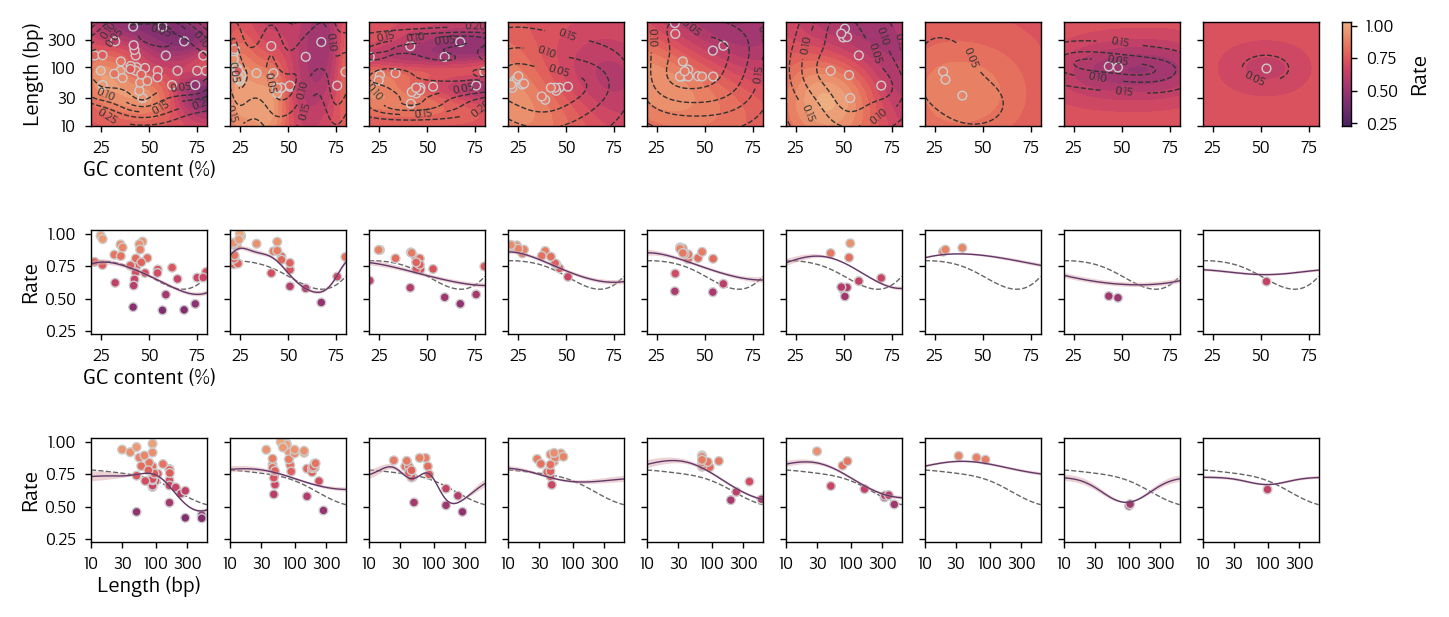

In [11]:
figsize = width, height = 7.083, 3
linewidth=0.5
ticklabelsize=6
labelsize=8
titlesize=labelsize+2

# Set rcParams for plotting
mpl.rc('xtick', labelsize=ticklabelsize)
mpl.rc('ytick', labelsize=ticklabelsize)
mpl.rc('axes', labelsize=labelsize, titlesize=titlesize, linewidth=linewidth)

# rnorm = mpl.colors.Normalize()
# rnorm(np.stack([r.μ for r in all_r]));
rnorm = mpl.colors.Normalize(vmin=0.23, vmax=1.03)

fig, axs = plt.subplots(3, 10, figsize=figsize)

for i, (r, row, ds) in enumerate(zip(all_r, axs.T, datasets)):
    ax = row[0]
    plt.sca(ax)
    pp = gmb.ParrayPlotter(x=GC, y=BP, z=r, 
                        #    x_scale='standardized',
                           y_scale='standardized'
                           )

    step = 0.05
    levels=np.arange(np.floor(rnorm.vmin/step), np.ceil(rnorm.vmax/step)+1)*step
    cs = pp(plt.contourf, levels=levels, cmap='flare_r', norm=rnorm)

    ax.set_yticks(BP_ticks.z.values())
    ax.set_xticks(GC_ticks.values())
    ax.set_xticklabels(map(int, 100*GC_ticks.values()))

    gc = ds.wide.GC
    bp = ds.wide.z.BP
    rs = ds.wide.r

    # ax.plot(gc, bp, ls='none', marker='.', mfc='0.5', mec='none', ms=5) #, cmap='flare_r', norm=rnorm)
    ax.scatter(gc, bp, c=rs, edgecolor='0.8', linewidths=0.5, s=10, cmap='flare_r', norm=rnorm)

    ax.set_xlim(limits['GC'].values())

    cs = ax.contour(GC.values(), BP.z.values(), r.σ, levels=[0.05, 0.10, 0.15, 0.20, 0.25], colors='0.2', linestyles='--', linewidths=0.5)
    ax.clabel(cs, fontsize=ticklabelsize-2);
    
    ax = row[1]
    plt.sca(ax)
    marginal = r.mean(axis=BP_idx)
    # ax.plot(gc, ds.wide.r, ls='none', marker='.', mfc='0.5', mec='none', ms=5, zorder=-10)
    ax.scatter(gc, rs, c=rs, edgecolor='0.8', linewidths=0.5, s=10, cmap='flare_r', norm=rnorm, zorder=-10)
    gmb.ParrayPlotter(GC_vec, marginal).plot(line_kws={'lw': 0.5})
    gmb.ParrayPlotter(GC_vec, avg_model_r.mean(axis=1).μ).plot(line_kws={'lw': 0.5, 'ls':'--', 'color':'0.4', 'zorder':-20})
    ax.set_xlim(limits['GC'].values())
    ax.set_ylim(rlim)
    ax.set_yticks(r_ticks.values())
    ax.set_xticks(GC_ticks.values())
    ax.set_xticklabels(map(int, 100*GC_ticks.values()))
    
    ax = row[2]
    plt.sca(ax)
    marginal = r.mean(axis=GC_idx)
    # ax.plot(bp, ds.wide.r, ls='none', marker='.', mfc='0.5', mec='none', ms=5, zorder=-10)
    ax.scatter(bp, rs, c=rs, edgecolor='0.8', linewidths=0.5, s=10, cmap='flare_r', norm=rnorm, zorder=-10)
    ax = gmb.ParrayPlotter(BP_vec.z, marginal).plot(line_kws={'lw': 0.5})
    gmb.ParrayPlotter(BP_vec.z, avg_model_r.mean(axis=0).μ).plot(line_kws={'lw': 0.5, 'ls':'--', 'color':'0.4', 'zorder':-20})
    ax.set_xlim(limits['BP'].z.values())
    ax.set_ylim(rlim)
    ax.set_yticks(r_ticks.values())
    ax.set_xticks(BP_ticks.z.values())
    ax.set_xticklabels(map(int, BP_ticks.values()))

for ax in axs.flat:
    ax.tick_params(axis='both', which='both', length=2, width=0.5)
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

axs[0,0].set_ylabel('Length (bp)', labelpad=1)
axs[0,0].set_xlabel('GC content (%)', labelpad=1)
axs[0,0].set_yticklabels(map(int, BP_ticks.values()))

axs[1,0].set_ylabel('Rate', labelpad=1)
axs[1,0].set_yticklabels(map('{:.2f}'.format, r_ticks.values()))
axs[1,0].set_xlabel('GC content (%)', labelpad=1)

axs[2,0].set_ylabel('Rate', labelpad=1)
axs[2,0].set_yticklabels(map('{:.2f}'.format, r_ticks.values()))
axs[2,0].set_xlabel('Length (bp)', labelpad=1);

"""Add fake colorbar"""

y = np.linspace(*rlim, 100)
x = np.zeros_like(y)
cax = axs[0,-1]
cax.imshow(y[::-1,None], cmap='flare_r', norm=rnorm, aspect=15, extent=[0,1,rlim[0],rlim[1]])
cax.yaxis.tick_right()
cax.yaxis.set_label_position("right")
cax.set_yticks(r_ticks.values())
cax.set_yticklabels(map('{:.2f}'.format, r_ticks.values()))
cax.set_ylabel('Rate')
cax.set_xticks([]);
        
mar_l=0.4
mar_r=-0.15
mar_t=0.05
mar_b=0.35

plt.subplots_adjust(
    hspace=1,
    left=mar_l / width,
    right=1 - mar_r / width,
    top=1 - mar_t / height,
    bottom=mar_b / height,
)

pos = cax.get_position()
x0 = axs[1,-1].get_position().x0
cax.set_position((x0, pos.y0, pos.width, pos.height))
for ax in axs[1:,-1]:
    ax.remove()
    
panel='A'
savefig()